# <u>Base Model</u>
In this notebook we will build a baseline model. We will compare basic logistic regression with xgboost model and evaluate their performance. Later, we will work on improving the model performance.  

In [65]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

In [66]:
df = pd.read_excel('orders_data.xlsx')

In [67]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,"CHANDIGARH,",CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,₹449.00,NaN,NaN,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_no      171 non-null    object
 1   order_date    171 non-null    object
 2   buyer         171 non-null    object
 3   ship_city     171 non-null    object
 4   ship_state    171 non-null    object
 5   sku           171 non-null    object
 6   description   171 non-null    object
 7   quantity      171 non-null    int64 
 8   item_total    153 non-null    object
 9   shipping_fee  145 non-null    object
 10  cod           47 non-null     object
 11  order_status  171 non-null    object
dtypes: int64(1), object(11)
memory usage: 16.2+ KB


### Handle Missing Data

In [69]:
df['cod'].fillna('Online', inplace=True)
df['shipping_fee'].fillna(df['shipping_fee'].mode()[0], inplace=True)
df['item_total'].fillna(df['item_total'].mode()[0], inplace=True)

In [70]:
def drop(df, *features):
    ''' To drop the features from a dataframe'''
    for i in features:
        df.drop(i, axis=1, inplace=True)

### Cleaning Data

In [71]:
# remove rupee symbol from amount features
amounts = ['item_total', 'shipping_fee']
for i in amounts:
    df[i] = df[i].apply(lambda x: x.replace(',', ''))        # remove the commas in amounts greater than 1000
    df[i] = df[i].apply(lambda x: x[1:])

In [72]:
# removing comma from city values
df['ship_city'] = df['ship_city'].apply(lambda x: x.replace(',', ''))
df['ship_state'] = df['ship_state'].apply(lambda x: x.replace(',', ''))

In [73]:
# extracting id from sku
df['sku'] = df['sku'].apply(lambda x: x[4:])

### Format Date

In [74]:
# extract year, month, day and time from date feature
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['month'] = pd.DatetimeIndex(df['order_date']).month
df['day'] = pd.DatetimeIndex(df['order_date']).dayofweek
df['time'] = pd.DatetimeIndex(df['order_date']).time

df['time'] = df['time'].apply(lambda x: (str(x))[:2])

In [75]:
# dropping order_no, order_date and buyer as they do not provide any extra information
drop(df, ['order_no', 'order_date', 'buyer'])

In [76]:
df.head(3)

,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,month,day,time
0,CHANDIGARH,CHANDIGARH,2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.00,84.96,Online,Delivered to buyer,2021,7,6,22
1,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.00,60.18,Online,Delivered to buyer,2021,10,1,18
2,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.00,60.18,Online,Delivered to buyer,2021,11,6,22


### Categorical Features

In [77]:
# changing values in binary categorical features to 0s and 1s
df['cod'] = df['cod'].map({'Cash On Delivery': 1, 'Online': 0})
df['order_status'] = df['order_status'].map({'Delivered to buyer': 1, 'Returned to seller': 0})

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ship_city     171 non-null    object
 1   ship_state    171 non-null    object
 2   sku           171 non-null    object
 3   description   171 non-null    object
 4   quantity      171 non-null    int64 
 5   item_total    171 non-null    object
 6   shipping_fee  171 non-null    object
 7   cod           171 non-null    int64 
 8   order_status  171 non-null    int64 
 9   year          171 non-null    int64 
 10  month         171 non-null    int64 
 11  day           171 non-null    int64 
 12  time          171 non-null    object
dtypes: int64(6), object(7)
memory usage: 17.5+ KB


In [79]:
# changing data types of numerical features
df['quantity'] = df['quantity'].astype('int64')
df['time'] = df['time'].astype('int64')
df['shipping_fee'] = df['shipping_fee'].astype('float64')
df['item_total'] = df['item_total'].astype('float64')

In [80]:
# label encode remaining categorical features
cat_features = [i for i in df.columns if df[i].dtypes == 'object']
for i in cat_features: 
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])

In [81]:
df.head()

,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,month,day,time
0,13,5,2,1,1,449.0,84.96,0,1,2021,7,6,22
1,56,1,22,59,1,449.0,60.18,0,1,2021,10,1,18
2,56,1,22,59,1,449.0,60.18,0,1,2021,11,6,22
3,18,24,17,30,1,449.0,84.96,1,1,2021,7,2,4
4,47,16,29,37,1,1099.0,84.96,0,1,2021,9,1,14


### Train Test Split

In [82]:
X = df.drop('order_status', axis=1)
y = df['order_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modeling

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, SCORERS, roc_curve, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [90]:
def model_result(model):
    ''' To calculate the accuracy score and confusion matrix of the provided model'''
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return score, cm

def plot_cm(score, cm, label):
    ''' To plot the confusion matrix'''
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)
    plt.title('{0} score: {1}'.format(label, round(score,4)), fontsize=20)
    plt.xlabel('Predicted Values', fontsize=20)
    plt.ylabel('Actual Values', fontsize=20)
    plt.show()

### Logistic Regression

In [91]:
lr = LogisticRegression(solver='liblinear', penalty='l1', random_state=42).fit(X_train, y_train)

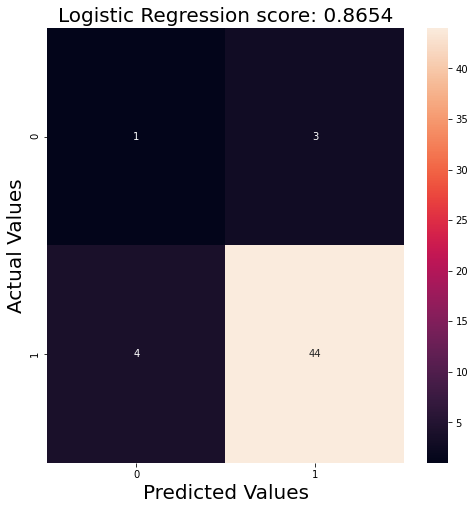

In [92]:
lr_score, lr_cm = model_result(lr)
plot_cm(lr_score, lr_cm, 'Logistic Regression')

### XGB Classifier

In [58]:
# tuning
params = { 'max_depth': range(6,15,1),
           'learning_rate': np.arange(0.01,0.1,0.1),
           'n_estimators': np.arange(100,800,50),
           'colsample_bytree': np.arange(0.3, 0.7,0.1)}

xgbc = XGBClassifier(seed = 20)
clf = RandomizedSearchCV(estimator=xgbc,
                   cv=3,
                   param_distributions=params,
                   scoring='accuracy', 
                   verbose=1,n_jobs=-1)
clf.fit(X_train,y_train)
print("Best parameters:", clf.best_params_)
print("Lowest mean squared wrr: ", (clf.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[19:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001}
Lowest mean squared wrr:  0.9412393162393163


In [63]:
xgb = XGBClassifier(n_estimators= 300, max_depth= 8, learning_rate= 0.01, colsample_bytree= 0.6).fit(X_train, y_train)

[19:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


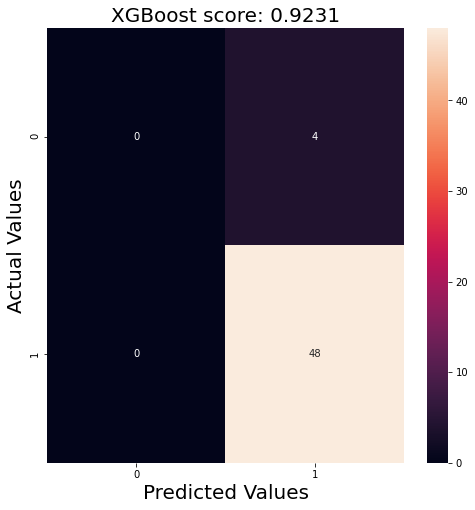

In [64]:
xgb_score, xgb_cm = model_result(xgb)
plt.figure(figsize=(8,8))
sns.heatmap(xgb_cm, annot=True)
plt.title('XGBoost score: {}'.format(round(xgb_score,4)), fontsize=20)
plt.xlabel('Predicted Values', fontsize=20)
plt.ylabel('Actual Values', fontsize=20)
plt.show()

## <u>Conclusions</u>

### Logistic Regression Model
Logistic Regression did not perform well in comparison to XGBoost model. We see a couple of false positives and false negatives.

### XGBoost Classifier Model
Even though the accuracy of our model is high, we infer that our model did not perform well because it could not classify any of the return orders correctly. The True positive is very high, it correctly classified all the successful orders which is quite good, but we need to work on reducing the false positives without compromising on the true positives.